# Data prep

In [1]:
import datasets
import pandas as pd

doc_dataset = datasets.load_dataset("m-ric/huggingface_doc", split="train")
qa_dataset = datasets.load_dataset("m-ric/huggingface_doc_qa_eval", split="train")

README.md:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

C:\Users\mk_ya\Desktop\NLP-playground\nlp-env\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\mk_ya\.cache\huggingface\hub\datasets--m-ric--huggingface_doc. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


huggingface_doc.csv:   0%|          | 0.00/22.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2647 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/893 [00:00<?, ?B/s]

C:\Users\mk_ya\Desktop\NLP-playground\nlp-env\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\mk_ya\.cache\huggingface\hub\datasets--m-ric--huggingface_doc_qa_eval. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


train-00000-of-00001.parquet:   0%|          | 0.00/289k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/65 [00:00<?, ? examples/s]

In [3]:
doc_df = pd.DataFrame(doc_dataset)
qa_df = pd.DataFrame(qa_dataset)

In [17]:
pd.set_option('display.max_colwidth', 100)
#pd.set_option('display.max_colwidth', None)

In [32]:
len(doc_df[doc_df['source']=='huggingface/tokenizers/blob/main/bindings/node/npm/linux-x64-musl/README.md']['text'].iloc[0])

96

In [33]:
len(qa_df.iloc[0]['context'])

96

In [12]:
doc_df.head()

,text,source
0,"Create an Endpoint\n\nAfter your first login, you will be directed to the [Endpoint creation pa...",huggingface/hf-endpoints-documentation/blob/main/docs/source/guides/create_endpoint.mdx
1,Choosing a metric for your task\n\n**So you've trained your model and want to see how well it’s...,huggingface/evaluate/blob/main/docs/source/choosing_a_metric.mdx
2,主要特点\n\n让我们来介绍一下 Gradio 最受欢迎的一些功能！这里是 Gradio 的主要特点：\n\n1. [添加示例输入](#example-inputs)\n2. [传递自定义错...,gradio-app/gradio/blob/main/guides/cn/01_getting-started/02_key-features.md
3,!--Copyright 2023 The HuggingFace Team. All rights reserved.\n\nLicensed under the Apache Licens...,huggingface/transformers/blob/main/docs/source/en/perf_train_tpu_tf.md
4,Gradio Demo: blocks_random_slider\n\n\n```\n!pip install -q gradio \n```\n\n\n```\n\nimport gra...,gradio-app/gradio/blob/main/demo/blocks_random_slider/run.ipynb


In [31]:
qa_df.head()

,context,question,answer,source_doc,standalone_score,standalone_eval,relatedness_score,relatedness_eval,relevance_score,relevance_eval
0,`tokenizers-linux-x64-musl`\n\nThis is the **x86_64-unknown-linux-musl** binary for `tokenizers`\n,What architecture is the `tokenizers-linux-x64-musl` binary designed for?\n,x86_64-unknown-linux-musl,huggingface/tokenizers/blob/main/bindings/node/npm/linux-x64-musl/README.md,5,"The question is asking about the specific architecture for which a binary file, named `tokenizer...",5,The context directly specifies the architecture for which the `tokenizers-linux-x64-musl` binary...,3,The question is asking for specific technical information regarding a binary file provided by th...
1,!--Copyright 2023 The HuggingFace Team. All rights reserved.\n\nLicensed under the Apache Licens...,What is the purpose of the BLIP-Diffusion model?\n,The BLIP-Diffusion model is designed for controllable text-to-image generation and editing.,huggingface/diffusers/blob/main/docs/source/en/api/pipelines/blip_diffusion.md,5,"The question is asking for the purpose of a specific model named ""BLIP-Diffusion."" While the mod...",5,"The context provides a detailed description of the BLIP-Diffusion model, including its purpose a...",3,"The question asks about the purpose of the BLIP-Diffusion model, which is a specific model that ..."
2,"Paper Pages\n\nPaper pages allow people to find artifacts related to a paper such as models, da...",How can a user claim authorship of a paper on the Hugging Face Hub?\n,"By clicking their name on the corresponding Paper page and clicking ""claim authorship"", then con...",huggingface/hub-docs/blob/main/docs/hub/paper-pages.md,5,The question is clear and does not depend on a specific context to be understood. It assumes a g...,5,The context provides a clear explanation of how a user can claim authorship of a paper on the Hu...,3,"The question is specific to the Hugging Face Hub, which is a platform used by machine learning d..."
3,Datasets server API\n\n> API on 🤗 datasets\n\n## Configuration\n\nThe service can be configured...,What is the purpose of the /healthcheck endpoint in the Datasets server API?\n,Ensure the app is running,huggingface/datasets-server/blob/main/services/api/README.md,5,The question is asking for the purpose of a specific feature (the /healthcheck endpoint) within ...,5,"The context directly states the purpose of the /healthcheck endpoint in the Datasets server API,...",4,"The question is specific and technical, asking about a particular feature (the /healthcheck endp..."
4,!--Copyright 2022 The HuggingFace Team. All rights reserved.\n\nLicensed under the Apache Licens...,What is the default context window size for Local Attention in the LongT5 model?\n,127 tokens,huggingface/transformers/blob/main/docs/source/en/model_doc/longt5.md,5,The question is asking for a specific parameter (default context window size) for a particular f...,5,The context provides a specific detail about the default context window size for Local Attention...,3,"This question is specific and technical, asking for a particular parameter of the Local Attentio..."


In [39]:
from langchain.docstore.document import Document as LangchainDocument
from tqdm.notebook import tqdm

In [41]:
RAW_KB = [
    LangchainDocument(page_content=doc["text"], metadata={"source": doc["source"]}) for doc in tqdm(doc_dataset)
]

  0%|          | 0/2647 [00:00<?, ?it/s]

# Chunking

In [45]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from typing import Optional, List, Tuple
from transformers import AutoTokenizer

# We use a hierarchical list of separators specifically tailored for splitting Markdown documents
# This list is taken from LangChain's MarkdownTextSplitter class
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

# Experiment embedding model, subject to change
EMBEDDING_MODEL_NAME = "thenlper/gte-small"


def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[LangchainDocument]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )

    docs_processed = []
    for doc in tqdm(RAW_KB, desc="Processing documents"):
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique


docs_processed = split_documents(
    512,  # We choose a chunk size adapted to our model
    RAW_KB,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

C:\Users\mk_ya\Desktop\NLP-playground\nlp-env\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\mk_ya\.cache\huggingface\hub\models--thenlper--gte-small. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Processing documents:   0%|          | 0/2647 [00:00<?, ?it/s]

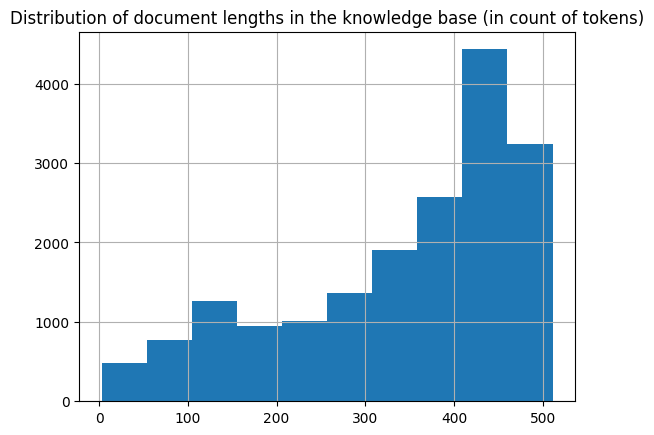

In [47]:
# Let's visualize the chunk sizes we would have in tokens from a common model
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

In [49]:
!pip install -U langchain-community

  Using cached typing_inspect-0.9.0-py3-none-any.whl.metadata (1.5 kB)
  Using cached python_dotenv-1.0.1-py3-none-any.whl.metadata (23 kB)
  Using cached mypy_extensions-1.0.0-py3-none-any.whl.metadata (1.1 kB)
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
    --------------------------------------- 0.0/2.4 MB 991.0 kB/s eta 0:00:03
   - -------------------------------------- 0.1/2.4 MB 787.7 kB/s eta 0:00:04
   -- ------------------------------------- 0.1/2.4 MB 1.4 MB/s eta 0:00:02
   --- ------------------------------------ 0.2/2.4 MB 1.3 MB/s eta 0:00:02
   --- ------------------------------------ 0.2/2.4 MB 1.1 MB/s eta 0:00:02
   ---- ----------------------------------- 0.3/2.4 MB 1.0 MB/s eta 0:00:03
   ----- ---------------------------------- 0.4/2.4 MB 1.2 MB/s eta 0:00:02
   ------ --------------------------------- 0.4/2.4 MB 1.2 MB/s eta 0:00:02
   ------- -------------------------------- 0.5/2.4 MB 1.2 MB/s eta 0:00:02
   --------- ------------------


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

# Save the FAISS index
KNOWLEDGE_VECTOR_DATABASE.save_local("faiss_index")

In [55]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

loaded_vectorstore = FAISS.load_local(
    "faiss_index", 
    embeddings=EMBEDDING_MODEL_NAME,
    allow_dangerous_deserialization=True
)

`embedding_function` is expected to be an Embeddings object, support for passing in a function will soon be removed.
